#This notebook has the construction of the elasticnet for the control data using duncan's embeddings

In [1]:
#importing lines and shaping up the data
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

embeddings_path=r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Testing_encodings\Duncan_embeddings\cellbox_duncan_embeddings.csv'
embeddings_df_raw=pd.read_csv(embeddings_path)
embeddings_df=embeddings_df_raw.iloc[1:,:]
one_hot_vectors=pd.read_csv(r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\data\pert.csv',header=None)
one_hot_vectors=one_hot_vectors.iloc[:,87:]

expression_matrix_path=r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Testing_encodings\Duncan_embeddings\control_node_names\expr.csv'
expression_matrix_raw=pd.read_csv(expression_matrix_path,header=None)
expression_matrix=expression_matrix_raw.iloc[:,:82]


In [2]:
#training models:
def model_training(input_matrix,output_matrix,alpha=1, l1_ratio=.5):
    elastic_model= ElasticNetCV(alphas=alpha,
                                 l1_ratio=l1_ratio,
                                 cv=5,
                                 max_iter=1000000,
                                 n_jobs=-1
                                )  # Adjust alpha and l1_ratio as needed
    #//////////train test split/////////
    x_train,x_test,y_train,y_test=train_test_split(input_matrix, output_matrix,train_size=.7)
    #/////////training model//////////////
    elastic_model.fit(x_train,y_train)

    #///////////evaluating model////////////
    output_matrix_pred = elastic_model.predict(x_test)
    mse = mean_squared_error(y_test, output_matrix_pred)
    r2 = r2_score(y_test, output_matrix_pred)

    return elastic_model, mse, r2,(x_train, x_test, y_train, y_test)  # Return the model and metrics along with the train/test data

def basic_lin_regr(input_matrix,output_matrix):

    from sklearn.linear_model import LinearRegression
    lin_model=LinearRegression()
    x_train,x_test,y_train,y_test=train_test_split(input_matrix,output_matrix,train_size=.7)
    lin_model.fit(x_train,y_train)

    #///////////evaluating model////////////
    output_matrix_pred = lin_model.predict(x_test)
    mse = mean_squared_error(y_test, output_matrix_pred)
    r2 = r2_score(y_test, output_matrix_pred)
    return lin_model,mse,r2,(x_train, x_test, y_train, y_test)

In [3]:
#make control matrices
def make_neg_control_matrices(input_matrix,output_matrix):
    #makes random matrices that therefore have no relationship
    neg_input_matrix = np.random.randn(*input_matrix.shape)
    neg_output_matrix = np.random.randn(*output_matrix.shape)
    return neg_input_matrix, neg_output_matrix

def make_pos_control_matrices(input_matrix,output_matrix):
    #makes random matrices, but also puts the actual values as the first columns
    pos_input_matrix = np.random.randn(*input_matrix.shape)
    pos_output_matrix = output_matrix
    #copy the n columns of the output matrix to the first n columns of the input matrix
    #and do some checking to make sure size is fine
    n = min(output_matrix.shape[1] if output_matrix.ndim > 1 else 1, input_matrix.shape[1])
    if n == 1:
        pos_input_matrix[:, 0] = output_matrix.ravel()
    else:
        pos_input_matrix[:, :n] = output_matrix[:, :n] if output_matrix.ndim > 1 else output_matrix.reshape(-1, 1)
    
    return pos_input_matrix, pos_output_matrix


In [4]:
#metrics for models:
def full_model_metrics(model, mse, r2, splits, model_type='elasticnet'):
    x_train, x_test, y_train, y_test = splits
    y_train_pred = model.predict(x_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    y_pred = model.predict(x_test)
    print_model_metrics(model, mse, r2, mse_train, r2_train, model_type)
    plot_predicted_vs_actual(y_test, y_pred, model_type)
    plot_predicted_vs_actual_zoomed(y_test, y_pred, model_type)
    plot_model_coefficients(model)

def print_model_metrics(model, mse, r2, mse_train, r2_train, model_type='elasticnet'):
    """
    Prints out the model statistics for training and test sets.
    """
    if model_type.lower() == "elasticnet":
        print("Elastic Net Model Statistics:")
        if hasattr(model, "alpha_"):
            print(f"Best alpha: {model.alpha_}")
        if hasattr(model, "l1_ratio_"):
            print(f"Best l1_ratio: {model.l1_ratio_}")
    elif model_type.lower() == "linear regression":
        print("Linear Regression Model Statistics:")
    else:
        print(f"{model_type} Model Statistics:")

    print(f"Mean Squared Error (MSE) on test set: {mse}")
    print(f"R^2 Score on test set: {r2}")
    print(f"Mean Squared Error (MSE) on training set: {mse_train}")
    print(f"R^2 Score on training set: {r2_train}")

def plot_predicted_vs_actual(y_test, y_pred, model_type='elasticnet'):
    """
    Plots predicted vs actual values for the test set.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    plt.figure(figsize=(7,7))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predicted vs Actual')
    min_val = min(np.min(y_test), np.min(y_pred))
    max_val = max(np.max(y_test), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (y=x)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_type.title()}: Predicted vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predicted_vs_actual_zoomed(y_test, y_pred, model_type='elasticnet'):
    """
    Plots predicted vs actual values for the test set, zoomed in to the -1 to 1 range.
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,7))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predicted vs Actual', s=15)
    plt.plot([-1, 1], [-1, 1], color='red', linestyle='--', label='Ideal Fit (y=x)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_type.title()}: Predicted vs Actual (Zoomed -1 to 1)')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_model_coefficients(model, title='Model Weights (Coefficients)'):
    """
    Plots the coefficients of a fitted linear model.

    Parameters:
        model: A fitted model object with a 'coef_' attribute.
        title (str): Title for the plot.
    """
    if not hasattr(model, 'coef_'):
        raise AttributeError("The provided model does not have a 'coef_' attribute.")
    coefs = model.coef_

    plt.figure(figsize=(10, 4))
    plt.bar(range(len(coefs)), coefs)
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Different methods for generating input and output matrices

In [6]:
#////////////TAKE 1/////////
#TO PREVENT OVERFITTING PREDICTED AS FOLLOWS:
#EACH ROW IS A PROTEIN OF INTEREST, AND TRIAL OF INTEREST,
#EACH COLUMN IS THE ENCODING FOR THE PROTEIN OF INTEREST WITH THEONE HOT VECTOR FOR THE TRIAL OF INTEREST
#INPUT MATRIX IS (NUM_TRIALSXNUM_PROTEINS, EMBEDDING_DIM+ONE_HOT_LENGTH)
#OUTPUT IS A SINGLE VALUE FOR EACH ROW, WHICH IS THE PROTEIN CONCENTRATION FOR THE PROTEIN OF INTEREST FOR THE TRIAL OF INTEREST
#RESHAPED OUTPUT IS (NUM_TRIALS,NUM_PROTEINS)
#///IMPLEMENTATION OF TAKE 1////
n_trials, n_onehot = one_hot_vectors.shape
n_proteins, n_embed = embeddings_df.shape
input_matrix=pd.DataFrame()


updated_embeddings=embeddings_df.transpose()
embeddings_np = updated_embeddings.to_numpy()
embeddings_tiled = np.tile(embeddings_np, (n_trials, 1))

 #/////////Norming the one_hot_vectors relative to the embeddings////////////
one_hot_vectors=one_hot_vectors.multiply(12/512)
one_hot_np = one_hot_vectors.to_numpy()
one_hot_repeated = np.repeat(one_hot_np, n_proteins, axis=0) 

# Concatenate to form the input matrix
# input_matrix_np = np.concatenate([embeddings_tiled,one_hot_repeated], axis=1)
# # Convert back to DataFrame, preserving column names
# input_matrix = pd.DataFrame(
#     input_matrix_np,
#     columns=list(one_hot_vectors.columns) +list(updated_embeddings.columns)
# )
# #GENERATING OUTPUT MATRIX:
# output_matrix = expression_matrix.to_numpy().flatten(order='C')  # row-major flattening
# output_matrix = output_matrix.reshape(-1, 1)  #


Testing the encodings

Elastic Net Model Statistics:
Mean Squared Error (MSE) on test set: 0.1105527839301914
R^2 Score on test set: 0.3624521191728042
Mean Squared Error (MSE) on training set: 0.12919279971346653
R^2 Score on training set: 0.36076251078160715


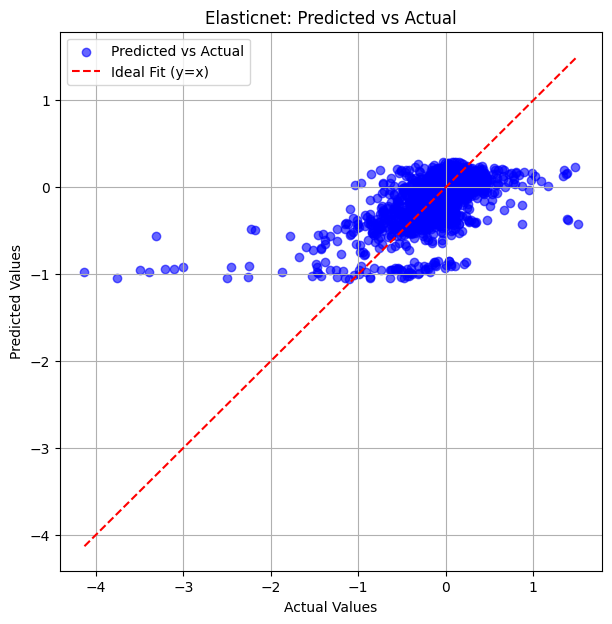

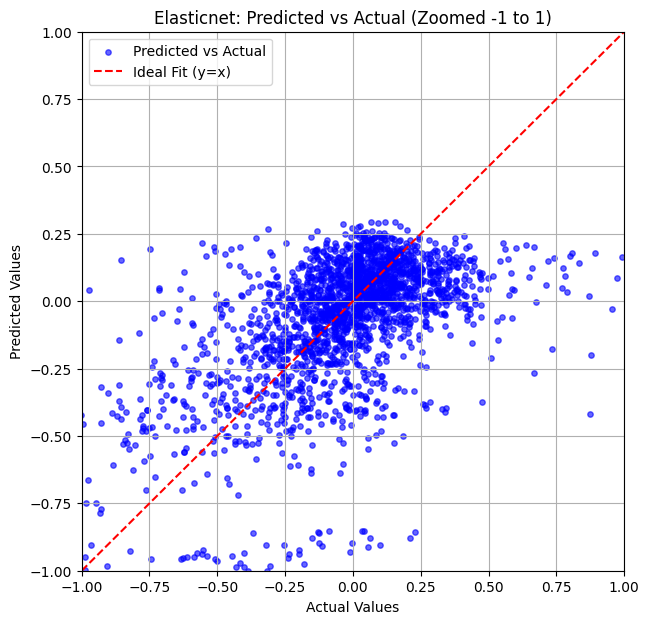

TypeError: only size-1 arrays can be converted to Python scalars

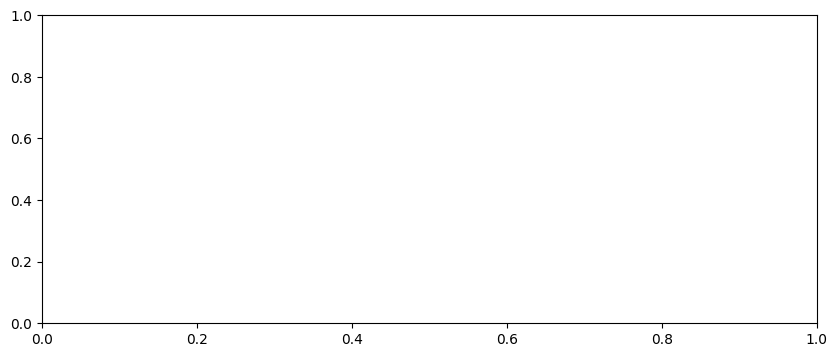

In [ ]:
#linear regression:
lin_model,mse,r2,splits=basic_lin_regr(input_matrix,output_matrix)
full_model_metrics(lin_model,mse,r2,splits)
#elastic net:
elastic_model,mse,r2,splits=model_training(input_matrix,output_matrix)
full_model_metrics(elastic_model,mse,r2,splits)
#positive and negative controls:
pos_input_matrix,pos_output_matrix=make_pos_control_matrices(input_matrix,output_matrix)
neg_input_matrix,neg_output_matrix=make_neg_control_matrices(input_matrix,output_matrix)


lin_model,mse,r2,splits=basic_lin_regr(pos_input_matrix,pos_output_matrix)
full_model_metrics(lin_model,mse,r2,splits)

lin_model,mse,r2,splits=basic_lin_regr(neg_input_matrix,neg_output_matrix)
full_model_metrics(lin_model,mse,r2,splits)


elastic_model,mse,r2,splits=model_training(pos_input_matrix,pos_output_matrix)
full_model_metrics(elastic_model,mse,r2,splits)

elastic_model,mse,r2,splits=model_training(neg_input_matrix,neg_output_matrix)
full_model_metrics(elastic_model,mse,r2,splits)